In [1]:
import backtrader as bt
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

In [2]:
start = '2014-01-01'
end = '2024-01-01'
SLV = yf.download(tickers='SLV', start=start, end=end, interval='1d').dropna()
SIL = yf.download(tickers='SIL', start=start, end=end, interval='1d').dropna()
date_list = SLV.index

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
slv = SLV['Adj Close'].to_numpy()
sil = SIL['Adj Close'].to_numpy()

In [4]:
class Ornstein_Uhlenbeck:
    def __init__(self, St1, St2):
        self.St1 = St1
        self.St2 = St2
        self.dt = 1 / 252
        self.n = self.St1.shape[0] - 1
        self.lb = np.zeros_like(0)
        self.ub = 1
        self.trial = 1000
        self.alpha = 1 / self.St1[0]
        self.k, self.X, self.mu, self.theta, self.sigma2 = self.get_best_parameters()
        self.beta = self.k / self.St2[0]
        
    def get_best_parameters(self):
        k_list = np.linspace(self.lb, self.ub, self.trial)
        best_l = - np.inf
        best_k, best_X, best_mu, best_theta, best_sigma2 = [None] * 5
        for k in k_list:
            beta = k / self.St2[0]
            X = self.alpha * self.St1 - beta * self.St2
            Xa = X[: -1]
            Xb = X[1: ]
            Sa = np.sum(Xa)
            Sb = np.sum(Xb)
            Saa = np.sum(Xa * Xa)
            Sbb = np.sum(Xb * Xb)
            Sab = np.sum(Xa * Xb)
            mu = (Sb * Saa - Sa * Sab) / (self.n * (Saa - Sab) + Sa * (Sb - Sa))
            theta = - np.log((Sab - mu * (Sa + Sb) + self.n * mu * mu) / (Saa - 2 * mu * Sa + self.n * mu * mu)) / self.dt
            gamma = np.exp(- theta * self.dt)
            sigma2 = 2 * theta * (Sbb - 2 * gamma * Sab + gamma ** 2 * Saa - 2 * mu * (1 - gamma) * (Sb - gamma * Sa) + self.n * (mu * (1 - gamma)) ** 2) / (self.n * (1 - gamma ** 2))
            if theta <= 0:
                continue
            l = - 0.5 * self.n * np.log(sigma2 / (2 * theta)) - 0.5 * self.n * np.log(1 - gamma ** 2) - theta * (Sbb - 2 * mu * Sb + self.n * mu ** 2 - 2 * gamma * Sab + 2 * gamma * mu * (Sa + Sb - self.n * mu) + gamma ** 2 * (Saa - 2 * mu * Sa + self.n * mu ** 2)) / (sigma2 * (1 - gamma ** 2))
            if l > best_l:
                best_l = l
                best_k, best_X, best_mu, best_theta, best_sigma2 = k, X, mu, theta, sigma2
        return best_k, best_X, best_mu, best_theta, best_sigma2

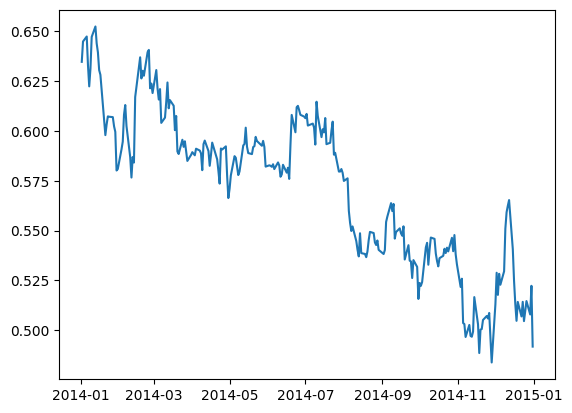

In [100]:
m1 = Ornstein_Uhlenbeck(slv[: 252], sil[: 252])
plt.plot(date_list[: 252], m1.X)

In [101]:

signal = np.zeros(len(date_list[252:]))
for i, date in enumerate(date_list[252:]):
    if i % 252 == 0:
        m1 = Ornstein_Uhlenbeck(slv[i: i + 252], sil[i: i + 252])
    Xt = m1.alpha * slv[i + 252] - m1.beta * sil[i + 252]
    if i == 0:
        if Xt > np.quantile(m1.X, 0.98):
            signal[i] = -1
        if Xt < np.quantile(m1.X, 0.02):
            signal[i] = 1
    else:
        if signal[i - 1] == 1:
            if Xt >= m1.mu:
                signal[i] = 0
            else: 
                signal[i] = 1
        elif signal[i - 1] == -1:
            if Xt <= m1.mu:
                signal[i] = 0
            else:
                signal[i] = -1
        else:
            if Xt > np.quantile(m1.X, 0.98):
                signal[i] = -1
            if Xt < np.quantile(m1.X, 0.02):
                signal[i] = 1

In [102]:
capital = 1000000
capital_list = np.zeros(len(date_list[252:]))
position = 0
price = 0
share = 0

for num, date in enumerate(date_list[252:]):
    if num % 252 == 0:
        if num != 0:
            m1 = Ornstein_Uhlenbeck(slv[num: num + 252], sil[num: num + 252])
            Xt = m1.alpha * slv[num + 252] - m1.beta * sil[num + 252]
            price = Xt
            share = capital / price
        else:
            m1 = Ornstein_Uhlenbeck(slv[num: num + 252], sil[num: num + 252])
    Xt = m1.alpha * slv[num + 252] - m1.beta * sil[num + 252]
    if position == 0:
        if signal[num] != 0:
            price = Xt
            share = capital / price
    elif position == 1:
        if signal[num] != 1:
            price = Xt
            capital = share * price
            if signal[num] == -1:
                share = capital / price
    elif position == -1:
        if signal[num] != -1:
            capital = share * (2 * price - Xt)
            if signal[num] == 1:
                share = capital / Xt
    position = signal[num]

    if position == 1:
        capital = share * Xt
    elif position == -1:
        capital = share * (2 * price - Xt)
    capital_list[num] = capital

    if capital <= 0:
        break
    if (num + 1) % 252 == 0 and num % 252 == 0:
        print(capital)

In [103]:
len(sil)

2516

In [104]:
best_alpha = None
best_capital = 0
for alpha in np.linspace(0.01, 0.5, 50):
    alpha = 0.05
    signal = np.zeros(len(date_list[252:]))
    for i, date in enumerate(date_list[252:]):
        if i % 252 == 0:
            m1 = Ornstein_Uhlenbeck(slv[i: i + 252], sil[i: i + 252])
        Xt = m1.alpha * slv[i + 252] - m1.beta * sil[i + 252]
        if i == 0:
            if Xt > np.quantile(m1.X, 1 - alpha):
                signal[i] = -1
            if Xt < np.quantile(m1.X, alpha):
                signal[i] = 1
        else:
            if signal[i - 1] == 1:
                if Xt >= m1.mu:
                    signal[i] = 0
                else:
                    signal[i] = 1
            elif signal[i - 1] == -1:
                if Xt <= m1.mu:
                    signal[i] = 0
                else:
                    signal[i] = -1
            else:
                if Xt > np.quantile(m1.X, 1 - alpha):
                    signal[i] = -1
                if Xt < np.quantile(m1.X, alpha):
                    signal[i] = 1
    capital = 1000000
    capital_list = np.zeros(len(date_list[252:]))
    position = 0
    price = 0
    share = 0
    
    for num, date in enumerate(date_list[252:]):
        if num % 252 == 0:
            if num != 0:
                m1 = Ornstein_Uhlenbeck(slv[num: num + 252], sil[num: num + 252])
                Xt = m1.alpha * slv[num + 252] - m1.beta * sil[num + 252]
                price = Xt
                share = capital / price
            else:
                m1 = Ornstein_Uhlenbeck(slv[num: num + 252], sil[num: num + 252])
        Xt = m1.alpha * slv[num + 252] - m1.beta * sil[num + 252]
        if position == 0:
            if signal[num] != 0:
                price = Xt
                share = capital / price
        elif position == 1:
            if signal[num] != 1:
                price = Xt
                capital = share * price
                if signal[num] == -1:
                    share = capital / price
        elif position == -1:
            if signal[num] != -1:
                capital = share * (2 * price - Xt)
                if signal[num] == 1:
                    share = capital / Xt
        position = signal[num]
    
        if position == 1:
            capital = share * Xt
        elif position == -1:
            capital = share * (2 * price - Xt)
        capital_list[num] = capital
    
        if capital <= 0:
            break
            
    if capital > best_capital:
        best_alpha = alpha
        best_capital = capital
        print(alpha, capital)
    
    break

0.05 6039096.936682506


In [105]:
capital

6039096.936682506

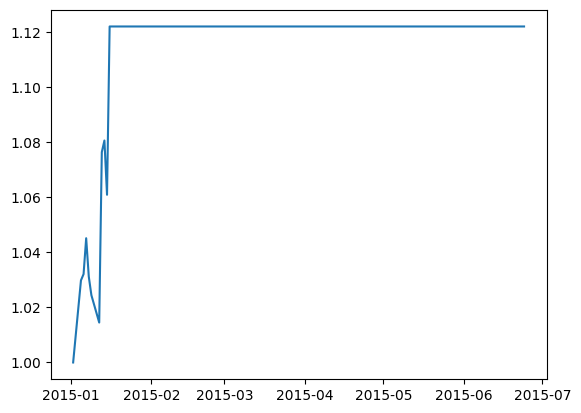

In [106]:
plt.plot(date_list[252:252+120], capital_list[:120] / capital_list[0])

In [107]:
capital_list / capital_list[0]

array([1.        , 1.02979435, 1.03206182, ..., 5.96923337, 5.98398037,
       6.03909694])

In [108]:
SPY = yf.download('SPY', start=start, end=end)['Adj Close']

[*********************100%%**********************]  1 of 1 completed


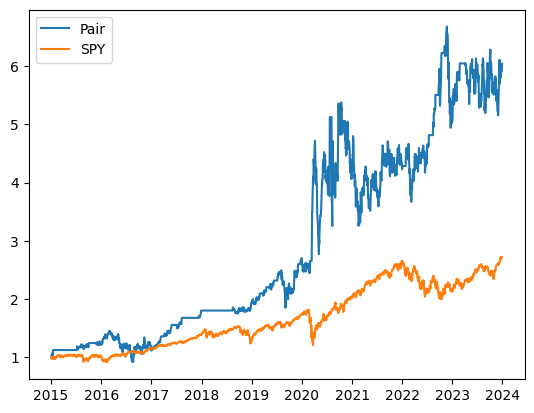

In [109]:
plt.plot(date_list[252:], capital_list / capital_list[0], label='Pair')
plt.plot(SPY.iloc[252:] / SPY.iloc[252], label='SPY')
plt.legend()